## imports

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

In [2]:
from a_star_search import load_model

In [3]:
model = load_model('models/DAVI_steps_15_10x10-longTraining-no-batchnorm_1565_10.565299987792969.pth', input_size=10*10*4)

In [4]:
import pyximport; pyximport.install()
pyximport.install(pyimport=True)

(<pyximport.pyximport.PyImporter at 0x7f42c02fcd50>, None)

In [5]:
import gzip
import pickle

In [6]:
import gc
gc.collect()

270

## solve games

In [7]:
from a_star_search import search_way
from tqdm import tqdm_notebook
import time
import numpy as np
from scipy.special._ufuncs import binom

actions_len_list = []
explored_len_list = []
possible_states_list = []
solve_time = []
results = []


with gzip.open('data/sokoban-v0.pkl.gz', 'rb') as f:
    envs = pickle.load(f)

for env in tqdm_notebook(envs):
    start_time = time.time()
    result, explored_len = search_way(env, model)
    if type(result) is list and len(result) > 0:
        solve_time.append(time.time() - start_time)
        actions_len_list.append(len(result))
        explored_len_list.append(len(result) / float(explored_len))
        x = sum((env.room_state > 0).flatten())
        possible_states_list.append(len(result) / x * binom(x-1, env.num_boxes))
        results.append(result)
    else:
        print('ERROR, could not find a path 😢')
        

7.4.0


 59%|█████▉    | 56416/95004 [10:38<07:17, 88.30it/s]

## statistics

In [8]:
print('actions_len_list', np.mean(actions_len_list))
print('explored_len_list', np.mean(explored_len_list) * 100)
print('possible_states_list', np.mean(possible_states_list))
print('solve_time', np.mean(solve_time))

actions_len_list 25.56
explored_len_list 2.116863774698985
possible_states_list 2989.336119013618
solve_time 298.72302765130996


In [9]:
temp = []
explored_len_list_ = []
possible_states_list = []
for env, result, explored_len in zip(envs, results, explored_len_list):
    x = sum((env.room_state > 0).flatten())
    explored_states = 1 / explored_len * len(result)
    explored_len_list_.append(explored_states)
    possible_states = x * binom(x-1, env.num_boxes)
    possible_states_list.append(possible_states)
    temp.append(explored_states / possible_states * 100)


In [10]:
stats = {
    'actions_len_list': actions_len_list,
    'explored_len_list': explored_len_list_,
    'possible_states_list': possible_states_list,
    'solve_time': solve_time,
    'results': results
}

with gzip.open(f'stats/sokoban-v0.pkl.gz', 'wb') as f:
    pickle.dump(stats, f, pickle.HIGHEST_PROTOCOL)

## plots

In [11]:
import matplotlib.pyplot as plt

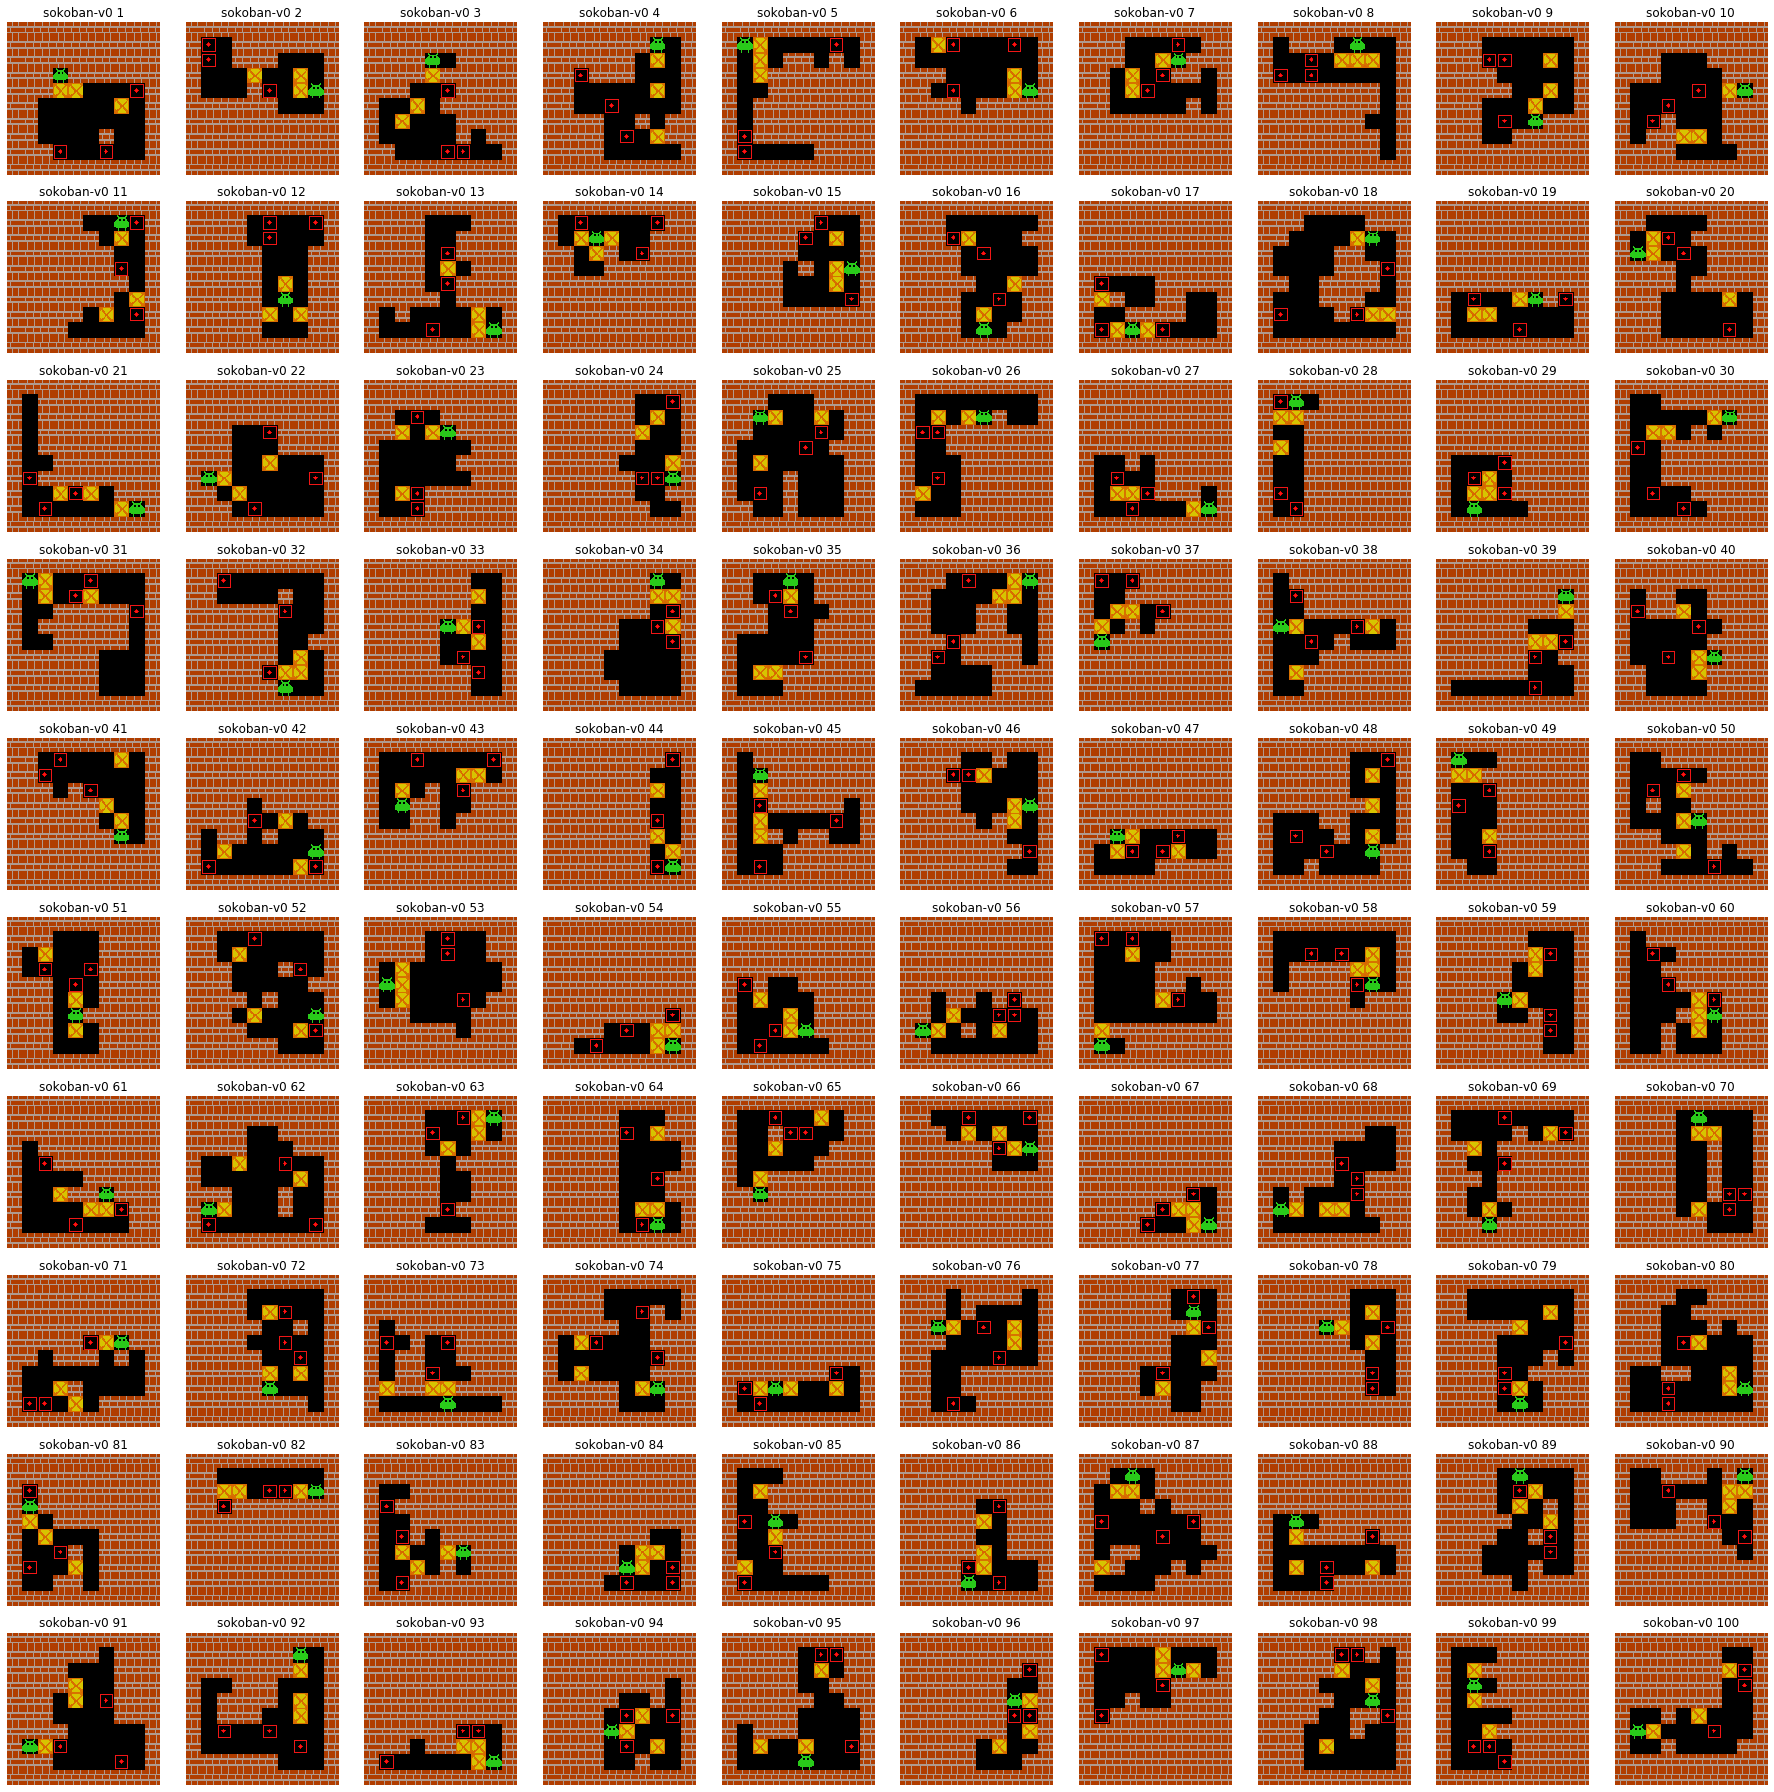

In [12]:
fig = plt.figure(figsize=(25, 25))
for idx, env in enumerate(envs):
    img = env.render(mode='rgb_array')
    fig.add_subplot(10, 10, idx + 1)
    plt.axis('off')
    plt.title(f'sokoban-v0 {idx + 1}')
    plt.imshow(img)
plt.axis('off')
fig.tight_layout()
plt.savefig("plots/sokoban-v0_unsolved.pdf")
plt.show()

In [ ]:
from copy import deepcopy

fig = plt.figure(figsize=(25, 25))
for idx, (env, actions) in enumerate(zip(envs, results)):
    env = deepcopy(env)
    
    step = 0
    for action in actions:
        next_state, reward, done, _ = env.step(action)
        step += 1
    
    img = env.render(mode='rgb_array')
    fig.add_subplot(10, 10, idx + 1)
    plt.axis('off')
    plt.title(f'sokoban-v0 {idx + 1}')
    plt.imshow(img)
plt.axis('off')
fig.tight_layout()
plt.savefig("plots/sokoban-v0_solved.pdf")
plt.show()